In [8]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models.model_config import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_14647/3250081078.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


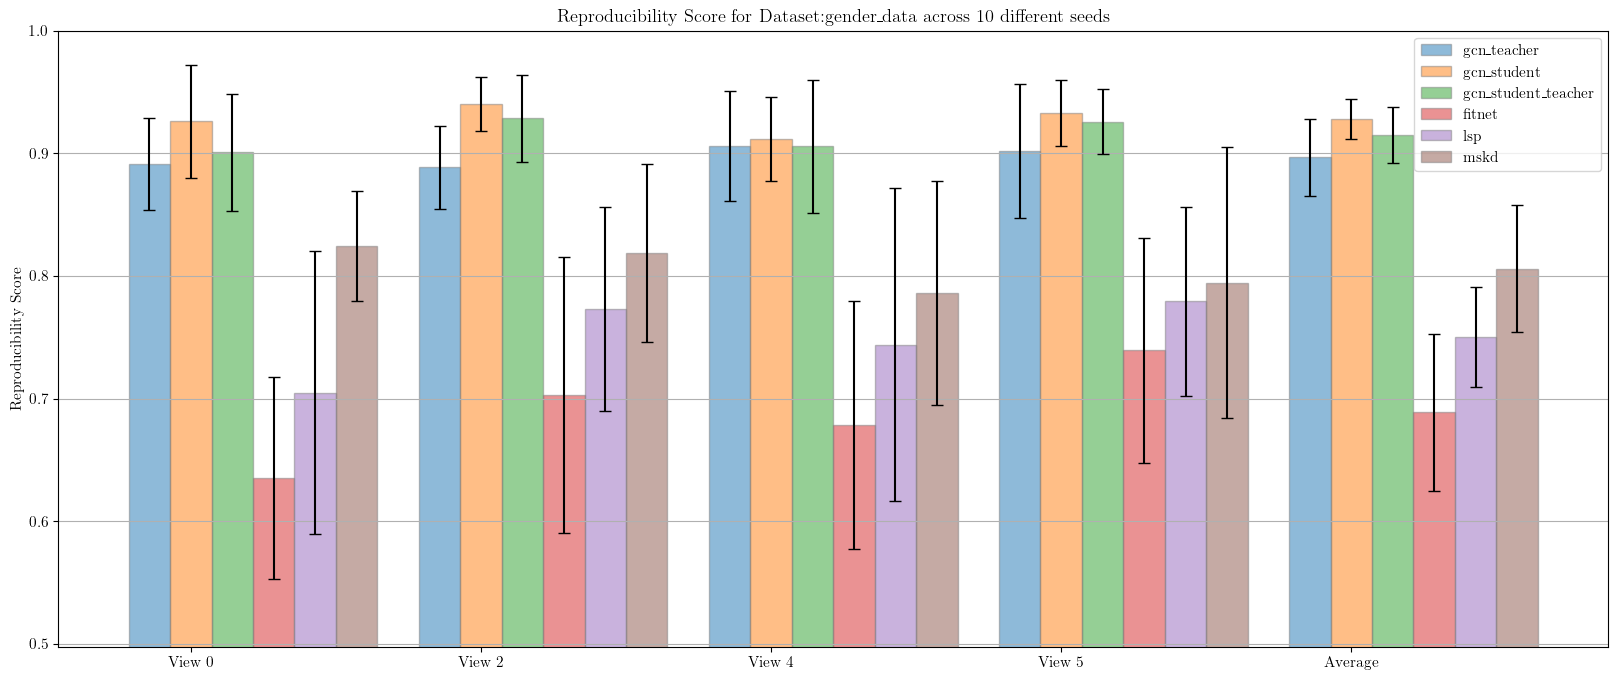

<Figure size 2000x800 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="gender_data"
views=[0, 2, 4, 5]
models=["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
model_args = [
    gcn_args, 
    gcn_student_args, 
    gcn_student_args, 
    gcn_fitnet_student_args,
    gcn_lsp_student_args,
    gcn_mskd_student_args
]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

In [54]:

def plot_bar_chart_metric_multiple_runs(dataset, view, models, CV, runs, metric, dataset_split, analysis_type, model_args=None, save_fig=False):
    """
    USAGE:

    ["acc", "f1", "recall", "precision"]
    for view in [0,2,4,5]:
        plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student","gcn_student_teacher"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="acc", dataset_split="val", analysis_type="model_assessment", save_fig=True)
        plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student","gcn_student_teacher",  "gcn_student_teacher_weight"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="f1", dataset_split="val", analysis_type="model_assessment", save_fig=True)
        plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student","gcn_student_teacher",  "gcn_student_teacher_weight"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="recall", dataset_split="val", analysis_type="model_assessment", save_fig=True)
        plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student","gcn_student_teacher",  "gcn_student_teacher_weight"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="precision", dataset_split="val", analysis_type="model_assessment", save_fig=True)    
    """
    plt.rcParams["figure.figsize"] = (10,8)
    plt.rcParams.update({'font.size': 18})

    barWidth = 1/(len(models)+1)

    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric=metric, dataset=dataset, dataset_split=dataset_split, analysis_type=analysis_type, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    #GET MEAN AND STD ACROSS MEAN OF RUNS
    mean_all_runs = np.c_[ mean_all_runs, np.mean(mean_all_runs, axis=1)]     
    mean_all_std = np.c_[ mean_all_std, np.std(mean_all_runs, axis=1)]  
    X = np.arange(len(CV)+1)
    sep = 0.00
    for i, view_d in enumerate(mean_all_runs):
        if models[i] == "gcn":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="Teacher", alpha=0.5)
        elif models[i] == "gcn_student": 
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="Student without Teacher", alpha=0.5)
        else:
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="Student with Teacher", alpha=0.5)
        
        sep += barWidth
    
    max_y_lim = np.amax(mean_all_runs) + 0.03
    min_y_lim = np.amin(mean_all_runs) - 0.03
    plt.ylim(min_y_lim, max_y_lim)
    
    #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
    if view ==0:
        title = f"Accuracy for Cortical Morphological Network $C_1$"
    if view==2:
        title = f"Accuracy for Cortical Morphological Network $C_2$"
    if view==4:
        title = f"Accuracy for Cortical Morphological Network $C_3$"
    if view==5:
        title = f"Accuracy for Cortical Morphological Network $C_4$"
    
    plt.ylabel(f"Accuracy")
    x_ticks = [i for i in CV]+ ["Average"]
    
    plt.xticks([r + barWidth for r in range(len(models)+1)], x_ticks)
    plt.title(title)
    plt.grid(axis = 'y')
    plt.legend()
    

    if save_fig:
        if not os.path.exists(SAVE_DIR_FIGS+"metric_results/"):
            os.makedirs(SAVE_DIR_FIGS+"metric_results/")
        
        plt.savefig(SAVE_DIR_FIGS+"metric_results/"+title+".png", dpi=150)
        plt.clf()
    
    else:
        plt.show()
        plt.clf()  

In [56]:
for view in [0,2,4,5]:
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student","gcn_student_teacher"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="acc", dataset_split="val", analysis_type="model_assessment", save_fig=True)


<Figure size 1000x800 with 0 Axes>